# K Means

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
import sklearn.metrics as metrics
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from munkres import Munkres

from lib.pca import PCAFeatures
import lib.bovw as bovw
from lib.alexnet import AlexNetFeatures
import lib.utils as utils

## 1. PCA Features

In [17]:
train_imgs, train_labels = utils.load_train_images()
print(len(train_imgs))

3500


In [4]:
train_resized_imgs = utils.resize_imgs(train_imgs)
mean_img = utils.get_mean_img(train_resized_imgs)
train_norm_imgs = utils.basic_imgs_normalization(train_resized_imgs)
train_features = utils.image_liniarization(train_norm_imgs)
train_features.shape

(3500, 7500)

In [5]:
pca_300 = PCAFeatures(dim=300)
pca_300.fit(train_features)
train_features_reduced_300 = pca_300.transform(train_features)
print(train_features_reduced_300.shape)

(3500, 300)


In [2]:
def kmeans_clustering(n_clusters, n_true_clusters, train_features, train_labels):
    """K Means clustering using given features, returns a fitted estimator
    and the predicted labels for the training data
    """
    # Fit the estimator and predict the labels
    k_means = KMeans(n_clusters, random_state=42)
    k_means.fit(train_features)
    predicted_labels = k_means.predict(train_features)

    # compute silhouette scores for every sample
    sil_avg = metrics.silhouette_score(train_features, predicted_labels)
    sample_sil_values = metrics.silhouette_samples(train_features, predicted_labels)
    
    # the silhouette plot for each cluster
    fig, ax = plt.subplots()
    ax.set_xlim([-0.1, 1])
    skip_between = 10
    ax.set_ylim([0, len(train_features) + (n_clusters + 1) * skip_between])

    y_min = 10
    for i in range(n_clusters):
        sil_values = sample_sil_values[predicted_labels == i]
        sil_values.sort()

        size = sil_values.shape[0]
        y_max = y_min + size

        color = cm.nipy_spectral(i / n_clusters)
        ax.fill_betweenx(
            np.arange(y_min, y_max),
            0,
            sil_values,
            facecolor=color,
            edgecolor=color,
        )

        ax.text(-0.1, y_min + 0.5 * size, str(i))
        y_min = y_max + skip_between

    ax.set_title(f"Silhouette plot for {n_clusters} clusters")
    ax.set_xlabel("Silhouette scores")
    ax.set_ylabel("Cluster")

    # plot the silhouette mean score
    ax.axvline(x=sil_avg, color="red")

    ax.set_yticks([])
    ax.set_xticks(np.arange(6) / 5)

    plt.show()

    # plot for K Means clustering vs. actual distribution
    fig, (ax1, ax2) = plt.subplots(1, 2)

    # use PCA for 2D plot
    pca_2 = PCAFeatures(2)
    pca_2.fit(train_features)
    train_features_2 = pca_2.transform(train_features)

    colors = cm.nipy_spectral(predicted_labels.astype(float) / n_clusters)
    ax1.scatter(
        train_features_2[:, 0], train_features_2[:, 1],
        marker='.', s=20, c=colors
    )
    # also plot cluster centers
    centers = pca_2.transform(k_means.cluster_centers_)
    ax1.scatter(
        centers[:, 0], centers[:, 1], marker='o',
        c="white", s=100, edgecolor='k'
    )
    ax1.set_title("Clustered data")
    ax1.axes.xaxis.set_visible(False)
    ax1.axes.yaxis.set_visible(False)

    colors = cm.nipy_spectral(
        np.array(train_labels).astype(float) / n_true_clusters
    )
    ax2.scatter(
        train_features_2[:, 0], train_features_2[:, 1],
        marker='.', s=20, c=colors
    )
    ax2.set_title("Actual distribution of the data")
    ax2.axes.xaxis.set_visible(False)
    ax2.axes.yaxis.set_visible(False)

    plt.show()

    return k_means, predicted_labels

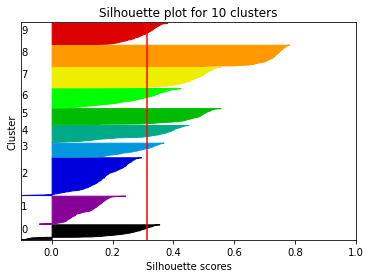

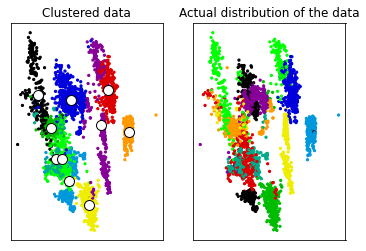

(3500,)

In [70]:
k_means, predicted_labels = kmeans_clustering(10, 10, train_features_reduced_300, train_labels)
predicted_labels.shape

Use the Hungarian algorithm in order to find the best matching between the clusters' labels and the actual class labels.

In [71]:
matching = Munkres()
contingency_matrix = metrics.cluster.contingency_matrix(train_labels, predicted_labels)
best_match = {}
for true, pred in matching.compute(contingency_matrix.max() - contingency_matrix):
    best_match[pred] = true
print(best_match)

{3: 0, 2: 1, 9: 2, 8: 3, 4: 4, 7: 5, 0: 6, 1: 7, 5: 8, 6: 9}


In [72]:
remapped_predicted_labels = [best_match[label] for label in predicted_labels]

In [73]:
print(f"Train ACC: {metrics.accuracy_score(train_labels, remapped_predicted_labels)}")

Train ACC: 0.808


In [74]:
print(f"Train NMI: {metrics.normalized_mutual_info_score(train_labels, remapped_predicted_labels)}")

Train NMI: 0.7923618911964304


In [75]:
test_imgs, test_labels = utils.load_test_images()
print(len(test_imgs))

1500


In [76]:
test_resized_imgs = utils.resize_imgs(test_imgs)
test_norm_imgs = utils.basic_imgs_normalization(test_resized_imgs, mean_img=mean_img)
test_features = utils.image_liniarization(test_norm_imgs)
test_features.shape

(1500, 7500)

In [77]:
test_features_reduced_300 = pca_300.transform(test_features)
print(test_features_reduced_300.shape)

(1500, 300)


In [78]:
test_predicted_labels = k_means.predict(test_features_reduced_300)
remapped_test_predicted_labels = [best_match[label] for label in test_predicted_labels]
print(len(remapped_test_predicted_labels))

1500


In [79]:
print(f"Test ACC: {metrics.accuracy_score(test_labels, remapped_test_predicted_labels)}")

Test ACC: 0.8093333333333333


In [80]:
print(f"Test NMI: {metrics.normalized_mutual_info_score(test_labels, remapped_test_predicted_labels)}")

Test NMI: 0.7932480746102336


## 2. BOVW

In [3]:
train_imgs, train_labels = utils.load_train_images_cv_grayscale()
print(len(train_imgs))

3500


In [4]:
bag_of_visual_words = bovw.BOVWFeatures(dim=4000)
train_features = bag_of_visual_words.fit_and_get_histograms(train_imgs)
print(train_features.shape)

Performing K-Means
Computing histograms
(3500, 4000)


In [16]:
train_features_norm = train_features / np.linalg.norm(train_features, axis=1).reshape((len(train_features), 1))
train_features_norm.shape

(3500, 4000)

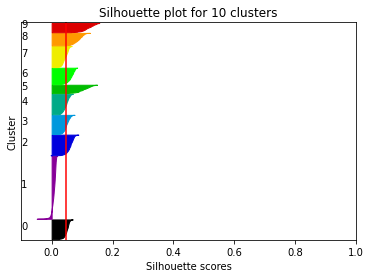

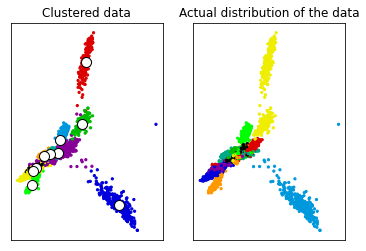

(3500,)

In [17]:
k_means, predicted_labels = kmeans_clustering(10, 10, train_features_norm, train_labels)
predicted_labels.shape

In [18]:
matching = Munkres()
contingency_matrix = metrics.cluster.contingency_matrix(train_labels, predicted_labels)
best_match = {}
for true, pred in matching.compute(contingency_matrix.max() - contingency_matrix):
    best_match[pred] = true
print(best_match)

{1: 0, 0: 1, 7: 2, 2: 3, 8: 4, 4: 5, 3: 6, 9: 7, 6: 8, 5: 9}


In [19]:
remapped_predicted_labels = [best_match[label] for label in predicted_labels]

In [20]:
print(f"Train ACC: {metrics.accuracy_score(train_labels, remapped_predicted_labels)}")

Train ACC: 0.7614285714285715


In [21]:
print(f"Train NMI: {metrics.normalized_mutual_info_score(train_labels, remapped_predicted_labels)}")

Train NMI: 0.8233593470689637


In [22]:
test_imgs, test_labels = utils.load_test_images_cv_grayscale()
print(len(test_imgs))

1500


In [26]:
test_features = bag_of_visual_words.get_histograms(test_imgs)
test_features_norm = test_features / np.linalg.norm(test_features, axis=1).reshape((len(test_features), 1))
test_predicted_labels = k_means.predict(test_features_norm)
remapped_test_predicted_labels = [best_match[label] for label in test_predicted_labels]
print(len(remapped_test_predicted_labels))

1500


In [27]:
print(f"Test ACC: {metrics.accuracy_score(test_labels, remapped_test_predicted_labels)}")

Test ACC: 0.7646666666666667


In [28]:
print(f"Test NMI: {metrics.normalized_mutual_info_score(test_labels, remapped_test_predicted_labels)}")

Test NMI: 0.8190057676979414


## 3. AlexNet Features

In [94]:
train_imgs, train_labels = utils.load_train_images(as_pil=True)
print(len(train_imgs))

3500


In [95]:
alexnet_features = AlexNetFeatures()
train_features = alexnet_features.get_embeddings(train_imgs)
train_features.shape

(3500, 64896)

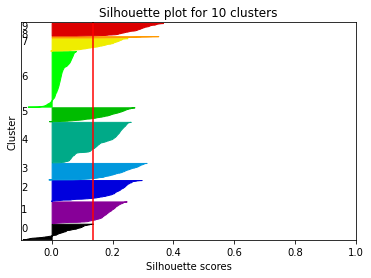

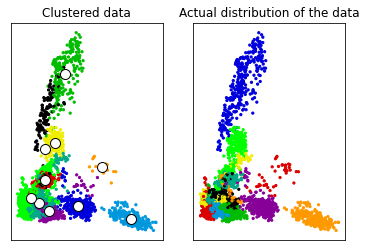

(3500,)

In [96]:
k_means, predicted_labels = kmeans_clustering(10, 10, train_features, train_labels)
predicted_labels.shape

In [97]:
matching = Munkres()
contingency_matrix = metrics.cluster.contingency_matrix(train_labels, predicted_labels)
best_match = {}
for true, pred in matching.compute(contingency_matrix.max() - contingency_matrix):
    best_match[pred] = true
print(best_match)

{0: 0, 2: 1, 5: 2, 4: 3, 9: 4, 1: 5, 7: 6, 8: 7, 3: 8, 6: 9}


In [98]:
remapped_predicted_labels = [best_match[label] for label in predicted_labels]

In [99]:
print(f"Train ACC: {metrics.accuracy_score(train_labels, remapped_predicted_labels)}")

Train ACC: 0.6788571428571428


In [101]:
print(f"Train NMI: {metrics.normalized_mutual_info_score(train_labels, remapped_predicted_labels)}")

Train NMI: 0.7043621701275309


In [102]:
test_imgs, test_labels = utils.load_test_images(as_pil=True)
print(len(test_imgs))

1500


In [103]:
test_features = alexnet_features.get_embeddings(test_imgs)
test_predicted_labels = k_means.predict(test_features)
remapped_test_predicted_labels = [best_match[label] for label in test_predicted_labels]
print(len(remapped_test_predicted_labels))

1500


In [104]:
print(f"Test ACC: {metrics.accuracy_score(test_labels, remapped_test_predicted_labels)}")

Test ACC: 0.682


In [105]:
print(f"Test NMI: {metrics.normalized_mutual_info_score(test_labels, remapped_test_predicted_labels)}")

Test NMI: 0.7050975168646685


## 4. Dlib Facenet Features

In [106]:
train_features = None
with open("./.emb_cache/dlib/train_embs.bin", "rb") as f:
    train_features = pickle.load(f)
train_features.shape

(3500, 128)

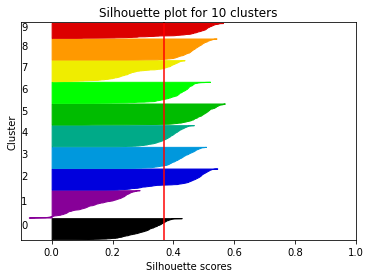

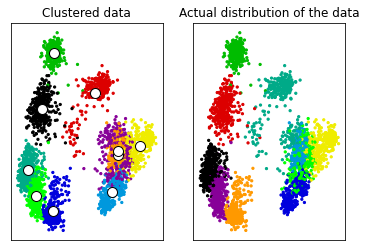

(3500,)

In [107]:
k_means, predicted_labels = kmeans_clustering(10, 10, train_features, train_labels)
predicted_labels.shape

In [108]:
matching = Munkres()
contingency_matrix = metrics.cluster.contingency_matrix(train_labels, predicted_labels)
best_match = {}
for true, pred in matching.compute(contingency_matrix.max() - contingency_matrix):
    best_match[pred] = true
print(best_match)

{4: 0, 6: 1, 3: 2, 8: 3, 9: 4, 5: 5, 1: 6, 7: 7, 2: 8, 0: 9}


In [109]:
remapped_predicted_labels = [best_match[label] for label in predicted_labels]

In [110]:
print(f"Train ACC: {metrics.accuracy_score(train_labels, remapped_predicted_labels)}")

Train ACC: 0.9702857142857143


In [112]:
print(f"Train NMI: {metrics.normalized_mutual_info_score(train_labels, remapped_predicted_labels)}")

Train NMI: 0.9708523969113168


In [114]:
test_features = None
with open("./.emb_cache/dlib/test_embs.bin", "rb") as f:
    test_features = pickle.load(f)
test_predicted_labels = k_means.predict(test_features)
remapped_test_predicted_labels = [best_match[label] for label in test_predicted_labels]
print(len(remapped_test_predicted_labels))

1500


In [115]:
print(f"Test ACC: {metrics.accuracy_score(test_labels, remapped_test_predicted_labels)}")

Test ACC: 0.9693333333333334


In [116]:
print(f"Test NMI: {metrics.normalized_mutual_info_score(test_labels, remapped_test_predicted_labels)}")

Test NMI: 0.9668616192526512
